# Reframing Design Pattern

The *Reframing design pattern* refers to changing the representation of the output of a machine learning problem. For example, we could take something that is intuitively a regression problem and instead pose it as a classification problem (and vice versa).

Let's look at the natality dataset. Notice that for a given set of inputs, the weight_pounds (the label) can take many different values. 

In [1]:
import numpy as np
import seaborn as sns
from google.cloud import bigquery

import matplotlib as plt
%matplotlib inline

In [2]:
bq = bigquery.Client()

In [3]:
query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = 38
  AND mother_age = 28
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.01
"""

In [4]:
df = bq.query(query).to_dataframe()
df.head()

,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race
0,7.187070,True,38,28,1,1
1,7.312733,True,38,28,1,1
2,6.801261,True,38,28,1,1
3,8.000575,True,38,28,1,1
4,8.811877,True,38,28,1,1


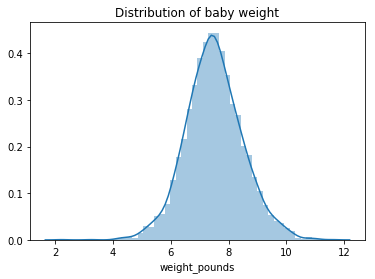

In [5]:
fig = sns.distplot(df[["weight_pounds"]])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")
fig.figure.savefig("weight_distrib.png")

In [6]:
#average weight_pounds for this cross section
np.mean(df.weight_pounds)

7.497811242931211

In [8]:
np.std(df.weight_pounds)

0.9896963447035907

In [14]:
weeks = 36
age = 28
query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = {}
  AND mother_age = {}
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.01
""".format(weeks, age)
df = bq.query(query).to_dataframe()
print('weeks={} age={} mean={} stddev={}'.format(weeks, age, np.mean(df.weight_pounds), np.std(df.weight_pounds)))

weeks=36 age=28 mean=6.734255476277215 stddev=1.1628149516815478


## Comparing categorical label and regression

Since baby weight is a positive real value, this is intuitively a regression problem. However, we can train the model as a multi-class classification by bucketizing the output label. At inference time, the model then predicts a collection of probabilities corresponding to these potential outputs. 

Let's do both and see how they compare. 

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

In [24]:
df = pd.read_csv("./data/babyweight_train.csv")

We'll use the same features for both models. But we need to create a categorical weight label for the classification model. 

In [26]:
# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

# create categorical label
def categorical_weight(weight_pounds):
    if weight_pounds < 3.31:
        return 0
    elif weight_pounds >= 3.31 and weight_pounds < 5.5:
        return 1
    elif weight_pounds >= 5.5 and weight_pounds < 8.8:
        return 2
    else:
        return 3

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x))

In [27]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,False,12,Single(1),40,1.0,2
1,7.561856,True,12,Single(1),40,2.0,2
2,7.187070,False,12,Single(1),34,3.0,2
3,6.375769,True,12,Single(1),36,2.0,2
4,7.936641,False,12,Single(1),35,0.0,2


In [28]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']

LABEL_CLS = ['weight_category']
LABEL_REG = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]

y_train_cls = encode_labels(df[LABEL_CLS][:N_TRAIN])
y_train_reg = df[LABEL_REG][:N_TRAIN]

y_valid_cls = encode_labels(df[LABEL_CLS][N_TRAIN:])
y_valid_reg = df[LABEL_REG][N_TRAIN:]

Create `tf.data` datsets for both classification and regression.

In [31]:
# train/validation dataset for classification model
cls_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_cls))
cls_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_cls))

# train/validation dataset for regression model
reg_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_reg.values))
reg_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_reg.values))

In [37]:
# Examine the two datasets. Notice the different label values.
for data_type in [cls_train_data, reg_train_data]:
    for dict_slice in data_type.take(1):
        print("{}\n".format(dict_slice))

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>)

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([7.74924851])>)



In [38]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

In [39]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# create hidden layers
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)

# create classification model
cls_output = layers.Dense(4, activation="softmax")(h2)
cls_model = tf.keras.models.Model(inputs=inputs, outputs=cls_output)
cls_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])   


# create regression model
reg_output = layers.Dense(1, activation="relu")(h2)
reg_model = tf.keras.models.Model(inputs=inputs, outputs=reg_output)
reg_model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])   

First, train the classification model and examine the validation accuracy. 

In [41]:
# train the classifcation model
cls_model.fit(cls_train_data.batch(50), epochs=1)

val_loss, val_accuracy = cls_model.evaluate(cls_valid_data.batch(X_valid.shape[0]))
print("Validation accuracy for classifcation model: {}".format(val_accuracy))

Train for 4234 steps
1/1 [==============================] - 1s 609ms/step - loss: 0.9457 - accuracy: 0.6750
Validation accuracy for classifcation model: 0.6749759316444397


Next, we'll train the regression model and examine the validation RMSE.

In [43]:
# train the classifcation model
reg_model.fit(reg_train_data.batch(50), epochs=1)

val_loss, val_mse = reg_model.evaluate(reg_valid_data.batch(X_valid.shape[0]))
print("Validation RMSE for regression model: {}".format(val_mse**0.5))

Train for 4234 steps
1/1 [==============================] - 1s 556ms/step - loss: 1.9008 - mse: 1.9008
Validation RMSE for regression model: 1.378703721169823


The regression model gives a single numeric prediction of baby weight. 

In [46]:
preds = reg_model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                             "is_male": tf.convert_to_tensor(["True"]),
                             "mother_age": tf.convert_to_tensor([28]),
                             "mother_race": tf.convert_to_tensor(["1.0"]),
                             "plurality": tf.convert_to_tensor(["Single(1)"])},
                          steps=1).squeeze()
preds

array(7.286859, dtype=float32)

The classification model predicts a probability for each bucket of values. 

In [47]:
preds = cls_model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                             "is_male": tf.convert_to_tensor(["True"]),
                             "mother_age": tf.convert_to_tensor([28]),
                             "mother_race": tf.convert_to_tensor(["1.0"]),
                             "plurality": tf.convert_to_tensor(["Single(1)"])},
                          steps=1).squeeze()
preds

array([7.7168038e-04, 5.1103556e-03, 9.3985993e-01, 5.4258034e-02],
      dtype=float32)

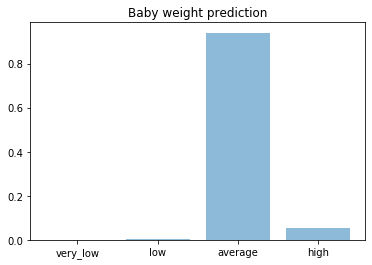

In [48]:
objects = ('very_low', 'low', 'average', 'high')
y_pos = np.arange(len(objects))
predictions = list(preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight prediction')

plt.show()

## Increasing the number of  categorical labels

We'll generalize the code above to accommodate `N` label buckets, instead of just 4. 

In [49]:
# Read in the data and preprocess
df = pd.read_csv("./data/babyweight_train.csv")

# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)
    
# create categorical label
MIN = np.min(df.weight_pounds)
MAX = np.max(df.weight_pounds)
NBUCKETS = 50

def categorical_weight(weight_pounds, weight_min, weight_max, nbuckets=10):
    buckets = np.linspace(weight_min, weight_max, nbuckets)
    
    return np.digitize(weight_pounds, buckets) - 1

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x, MIN, MAX, NBUCKETS))

In [50]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL_COLUMN = ['weight_category']

N_TRAIN = int(df.shape[0] * 0.80)

X_train, y_train = df[FEATURES][:N_TRAIN], encode_labels(df[LABEL_COLUMN][:N_TRAIN])
X_valid, y_valid = df[FEATURES][N_TRAIN:], encode_labels(df[LABEL_COLUMN][N_TRAIN:])

In [51]:
# create the training dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid))

Create the feature columns and build the model. 

In [52]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

In [53]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# model
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)
output = layers.Dense(NBUCKETS, activation="softmax")(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])  

In [54]:
# train the model
model.fit(train_data.batch(50), epochs=1)

Train for 4234 steps
4234/4234 [==============================] - 20s 5ms/step - loss: 2.5945 - accuracy: 0.1329


Make a prediction on the example above. 

In [20]:
preds = model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                         "is_male": tf.convert_to_tensor(["True"]),
                         "mother_age": tf.convert_to_tensor([28]),
                         "mother_race": tf.convert_to_tensor(["1.0"]),
                         "plurality": tf.convert_to_tensor(["Single(1)"])},
                      steps=1).squeeze()

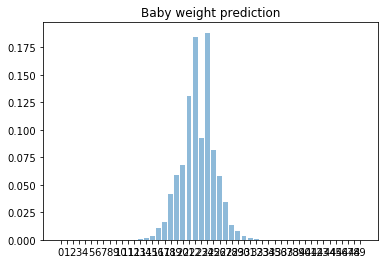

In [23]:
objects = [str(_) for _ in range(NBUCKETS)]
y_pos = np.arange(len(objects))
predictions = list(preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight prediction')

plt.show()

## Restricting the prediction range

One way to restrict the prediction range is to make the last-but-one activation function sigmoid instead, and add a lambda layer to scale the (0,1) values to the desired range. The drawback is that it will be difficult for the neural network to reach the extreme values.

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

MIN_Y =  3
MAX_Y = 20
input_size = 10
inputs = keras.layers.Input(shape=(input_size,))
h1 = keras.layers.Dense(20, 'relu')(inputs)
h2 = keras.layers.Dense(1, 'sigmoid')(h1)  # 0-1 range
output = keras.layers.Lambda(lambda y : (y*(MAX_Y-MIN_Y) + MIN_Y))(h2) # scaled
model = keras.Model(inputs, output)

# fit the model
model.compile(optimizer='adam', loss='mse')
batch_size = 2048
for i in range(0, 10):
    x = np.random.rand(batch_size, input_size)
    y = 0.5*(x[:,0] + x[:,1]) * (MAX_Y-MIN_Y) + MIN_Y
    model.fit(x, y)

# verify
min_y = np.finfo(np.float64).max
max_y = np.finfo(np.float64).min
for i in range(0, 10):
    x = np.random.randn(batch_size, input_size)
    y = model.predict(x)
    min_y = min(y.min(), min_y)
    max_y = max(y.max(), max_y)
print('min={} max={}'.format(min_y, max_y))

Train on 2048 samples
2048/2048 [==============================] - 1s 259us/sample - loss: 12.7289
Train on 2048 samples
2048/2048 [==============================] - 0s 131us/sample - loss: 9.4002
Train on 2048 samples
2048/2048 [==============================] - 0s 143us/sample - loss: 6.7786
Train on 2048 samples
2048/2048 [==============================] - 0s 117us/sample - loss: 4.5199
Train on 2048 samples
2048/2048 [==============================] - 0s 145us/sample - loss: 3.1557
Train on 2048 samples
2048/2048 [==============================] - 0s 143us/sample - loss: 2.2014
Train on 2048 samples
2048/2048 [==============================] - 0s 116us/sample - loss: 1.5578
Train on 2048 samples
2048/2048 [==============================] - 0s 125us/sample - loss: 1.1570
Train on 2048 samples
2048/2048 [==============================] - 0s 118us/sample - loss: 0.8444
Train on 2048 samples
2048/2048 [==============================] - 0s 175us/sample - loss: 0.6425
min=3.0291719436645

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License